In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Load dataset
movies = pd.read_csv('dataset/movies.csv')
ratings = pd.read_csv('dataset/ratings.csv')

In [4]:
# Merge datasets
data = pd.merge(ratings, movies, on='movieId')

# Preprocess: Combine title and genres for a simplistic content-based filtering approach
data['content'] = data['title'] + " " + data['genres']

# Vectorize content using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['content'])

# Encoding user IDs and movie IDs
user_encoder = LabelEncoder()
data['userId'] = user_encoder.fit_transform(data['userId'])

movie_encoder = LabelEncoder()
data['movieId'] = movie_encoder.fit_transform(data['movieId'])

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
# Custom Dataset Class
class MovieDataset(Dataset):
    def __init__(self, user_ids, movie_ids, ratings):
        self.user_ids = torch.tensor(torch.Tensor(user_ids.to_numpy()), dtype=torch.long)
        self.movie_ids = torch.tensor(torch.Tensor(movie_ids.to_numpy()), dtype=torch.long)
        self.ratings = torch.tensor(torch.Tensor(ratings.to_numpy()), dtype=torch.float32)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

# Creating datasets
train_dataset = MovieDataset(train_data['userId'], train_data['movieId'], train_data['rating'])
test_dataset = MovieDataset(test_data['userId'], test_data['movieId'], test_data['rating'])

# DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

C:\Users\MSI\AppData\Local\Temp\ipykernel_22144\3037696267.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.user_ids = torch.tensor(torch.Tensor(user_ids.to_numpy()), dtype=torch.long)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22144\3037696267.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.movie_ids = torch.tensor(torch.Tensor(movie_ids.to_numpy()), dtype=torch.long)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22144\3037696267.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ratings = torch.tensor(torch.Tensor(rati

In [6]:
# Movie Recommendation Model
class MovieRecommendationModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(MovieRecommendationModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, user_id, movie_id):
        user_embedded = self.user_embedding(user_id)
        movie_embedded = self.movie_embedding(movie_id)
        x = torch.cat([user_embedded, movie_embedded], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        rating = self.fc3(x)
        return rating



In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print(device)

cpu


In [9]:
# Instantiate the model and move it to GPU
num_users = len(data['userId'].unique())
num_movies = len(data['movieId'].unique())
model = MovieRecommendationModel(num_users, num_movies).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize variables for early stopping
best_test_loss = float('inf')
best_test_accuracy = 0.0
patience = 5
patience_counter = 0
model_save_path = 'best_movie_recommendation_model.pth'

# Lists to store metrics for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [10]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for user_id, movie_id, rating in loader:
            user_id = user_id.to(device)
            movie_id = movie_id.to(device)
            rating = rating.to(device)

            outputs = model(user_id, movie_id).squeeze()
            predicted_ratings = outputs.round()  # round the predicted ratings to the nearest integer
            correct += (predicted_ratings == rating.round()).sum().item()
            total += rating.size(0)

    return correct / total



In [11]:
# Training loop with early stopping
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for user_id, movie_id, rating in train_loader:
        # Move data to GPU
        user_id = user_id.to(device)
        movie_id = movie_id.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        outputs = model(user_id, movie_id).squeeze()
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = calculate_accuracy(train_loader, model)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Store training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for user_id, movie_id, rating in test_loader:
            # Move data to GPU
            user_id = user_id.to(device)
            movie_id = movie_id.to(device)
            rating = rating.to(device)
            
            # Forward pass (outputs will be on GPU)
            outputs = model(user_id, movie_id).squeeze()
            
            # Compute loss on GPU
            loss = criterion(outputs, rating)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    # Store test metrics
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    # Check if the current test loss is the best we've seen
    if avg_test_loss < best_test_loss or test_accuracy > best_test_accuracy:
        print(f'Saving model with Test Loss {avg_test_loss:.4f} and Test Accuracy {test_accuracy:.4f}')
        best_test_loss = avg_test_loss
        best_test_accuracy = test_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        print(f'No improvement in test loss or accuracy for {patience_counter} epochs.')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break

print('Training complete')


Epoch 1/50, Training Loss: 0.7869, Training Accuracy: 0.4908
Test Loss: 0.7998, Test Accuracy: 0.4709
Saving model with Test Loss 0.7998 and Test Accuracy 0.4709
Epoch 2/50, Training Loss: 0.7643, Training Accuracy: 0.5002
Test Loss: 0.7826, Test Accuracy: 0.4867
Saving model with Test Loss 0.7826 and Test Accuracy 0.4867
Epoch 3/50, Training Loss: 0.7612, Training Accuracy: 0.5074
Test Loss: 0.7708, Test Accuracy: 0.4944
Saving model with Test Loss 0.7708 and Test Accuracy 0.4944
Epoch 4/50, Training Loss: 0.7359, Training Accuracy: 0.5167
Test Loss: 0.7545, Test Accuracy: 0.4956
Saving model with Test Loss 0.7545 and Test Accuracy 0.4956
Epoch 5/50, Training Loss: 0.7219, Training Accuracy: 0.5245
Test Loss: 0.7331, Test Accuracy: 0.5162
Saving model with Test Loss 0.7331 and Test Accuracy 0.5162
Epoch 6/50, Training Loss: 0.6986, Training Accuracy: 0.5343
Test Loss: 0.7216, Test Accuracy: 0.5259
Saving model with Test Loss 0.7216 and Test Accuracy 0.5259
Epoch 7/50, Training Loss: 0

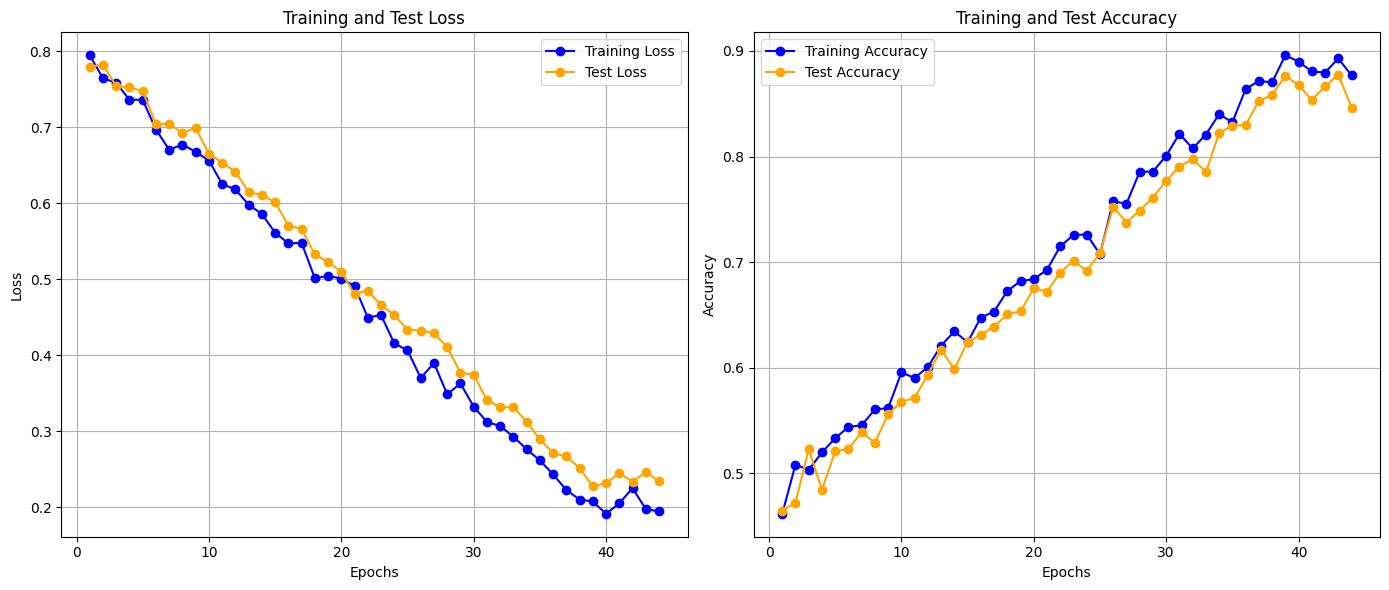

In [13]:
# Plotting training and test metrics
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()


In [14]:
# Load the best model for inference
# model.load_state_dict(torch.load(model_save_path))
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
model.eval()

# Sentiment Analysis Initialization
sia = SentimentIntensityAnalyzer()



In [15]:
def analyze_sentiment(description):
    sentiment_scores = sia.polarity_scores(description)
    return sentiment_scores



In [16]:
# Movie Recommendation Function with Sentiment Analysis
def recommend_movies(user_id, description, num_recommendations=5):
    model.eval()
    
    # Analyze sentiment of the user's description
    sentiment_scores = analyze_sentiment(description)
    sentiment_factor = 1 + sentiment_scores['compound'] * 0.1  # Adjust factor based on sentiment
    print(sentiment_factor)    ##### Delete this
    
    # Move user_id_tensor to GPU
    user_id_tensor = torch.tensor([user_id], dtype=torch.long).to(device)
    
    predictions = []
    for movie_id in range(num_movies):
        # Move movie_id_tensor to GPU
        movie_id_tensor = torch.tensor([movie_id], dtype=torch.long).to(device)
        
        # Predict rating without computing gradients
        with torch.no_grad():
            predicted_rating = model(user_id_tensor, movie_id_tensor).item()
        
        # Adjust predicted rating based on sentiment
        adjusted_rating = predicted_rating * sentiment_factor
        predictions.append((movie_id, adjusted_rating))
    
    # Sort movies by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N recommendations
    recommended_movie_ids = [movie_id for movie_id, _ in predictions[:num_recommendations]]
    
    # Decode movie IDs and get the corresponding titles
    recommended_movie_titles = []
    for mid in recommended_movie_ids:
        original_movie_id = movie_encoder.inverse_transform([mid])[0]
        movie_title = movies[movies['movieId'] == original_movie_id]['title'].values[0]
        recommended_movie_titles.append(movie_title)
    
    return recommended_movie_titles



In [17]:
# Example usage
user_id = 1
description = "I love heartwarming movies with positive and uplifting stories."
recommendations = recommend_movies(user_id, description)
print(recommendations)

1.08979
['Shawshank Redemption, The (1994)', 'Dark Knight, The (2008)', 'Planet Earth II (2016)', 'Whiplash (2013)', 'Braveheart (1995)']


In [18]:
# Example usage
user_id = 2
description = "I love heartwarming movies with positive and uplifting stories."
recommendations = recommend_movies(user_id, description)
print(recommendations)

1.08979
['3 Idiots (2009)', 'Piper (2016)', 'Civil War, The (1990)', 'Presto (2008)', 'Blue Planet II (2017)']


In [19]:
# Example usage
user_id = 2100
description = "I like to watch more romantic movies"
recommendations = recommend_movies(user_id, description)
print(recommendations)

1.06697
['Planet Earth II (2016)', 'Planet Earth (2006)', 'Godfather, The (1972)', 'Shawshank Redemption, The (1994)', 'Blue Planet II (2017)']


In [23]:
# Example usage
user_id = 1000
description = "I hate romantic movies and like comedies"
recommendations = recommend_movies(user_id, description)
print(recommendations)

1.04939
['Cosmos', 'Star Wars: Episode IV - A New Hope (1977)', 'The Blue Planet (2001)', 'Die Hard (1988)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)']
